<h1>C4 Solution</h1>

<h3>Get the data and copy it to S3</h3>

In [ ]:
%%capture
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip

In [2]:
%%capture
!unzip dogImages.zip

In [3]:
%%capture
!aws s3 cp dogImages s3://udacitysolution/ --recursive

<h3>Install and import</h3>

In [2]:
%%capture
!pip install smdebug torch torchvision tqdm

In [3]:
import sagemaker
import boto3
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile
import os

<h3>Set up parameters, estimator, and tuner</h3>

In [4]:
hyperparameter_ranges = {
    "learning_rate": ContinuousParameter(0.001, 0.1),
    "batch_size": CategoricalParameter([32, 64, 128, 256, 512]),
}

role = sagemaker.get_execution_role()

objective_metric_name = "Test Loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "Test Loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]

In [5]:
estimator = PyTorch(
    entry_point="hpo.py",
    base_job_name='pytorch_dog_hpo',
    role=role,
    framework_version="1.4.0",
    instance_count=1,
    instance_type="ml.m5.xlarge",
    py_version='py3'
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=2,
    max_parallel_jobs=2,
    objective_type=objective_type
)

<h3>Fit the tuner</h3>

In [6]:
bucket = 'edgarin-mlend'
data_prefix = "prj-dogbreed/dogImages"
data_s3_uri = f"s3://{bucket}/{data_prefix}"

uc_uri = f"s3://{bucket}/uc-dogbreed"



In [ ]:
# os.environ['SM_CHANNEL_TRAINING']='s3://udacitysolution/'
os.environ['SM_CHANNEL_TRAINING'] = data_s3_uri
os.environ['SM_MODEL_DIR'] = f'{uc_uri}/model/'
os.environ['SM_OUTPUT_DATA_DIR'] = f'{uc_uri}/output/'
#tuner.fit({"training": "s3://udacitysolution/"})
tuner.fit({"training": data_s3_uri})

.........................................................................................................................................................................................................

<h3>Describe the tuning results</h3>


In [10]:
from sagemaker.analytics import HyperparameterTuningJobAnalytics

exp = HyperparameterTuningJobAnalytics(
  hyperparameter_tuning_job_name='pytorch-training-220124-2250')

jobs = exp.dataframe()

jobs.sort_values('FinalObjectiveValue', ascending=0)

,batch_size,learning_rate,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,"""128""",0.036378,pytorch-training-220124-2250-002-83d1be90,Completed,606.0,2022-01-24 22:52:58+00:00,2022-01-24 23:13:06+00:00,1208.0
1,"""128""",0.001282,pytorch-training-220124-2250-001-90a63540,Completed,269.0,2022-01-24 22:52:57+00:00,2022-01-24 23:13:05+00:00,1208.0


## Imp: If kernel dies, how to continue from a completed training job

In [8]:
#BetterTrainingJobName='pytorch-training-220124-2250-001-90a63540'

In [9]:
#my_estimator = sagemaker.estimator.Estimator.attach(BetterTrainingJobName)


In [10]:
#my_estimator.hyperparameters()

In [11]:
#best_estimator=my_estimator

<h3>Prepare to perform Training on Best Estimator</h3>

In [11]:
best_estimator=tuner.best_estimator()


2022-01-24 23:13:05 Starting - Preparing the instances for training
2022-01-24 23:13:05 Downloading - Downloading input data
2022-01-24 23:13:05 Training - Training image download completed. Training in progress.
2022-01-24 23:13:05 Uploading - Uploading generated training model
2022-01-24 23:13:05 Completed - Training job completed


In [12]:
best_estimator.hyperparameters()

{'_tuning_objective_metric': '"Test Loss"',
 'batch_size': '"128"',
 'learning_rate': '0.0012821332678663788',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch_dog_hpo-2022-01-24-22-50-23-351"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-784712499272/pytorch_dog_hpo-2022-01-24-22-50-23-351/source/sourcedir.tar.gz"'}

In [13]:
hyperparameters = {"batch_size": int(best_estimator.hyperparameters()['batch_size'].replace('"', '')), \
                   "learning_rate": best_estimator.hyperparameters()['learning_rate']}
hyperparameters

{'batch_size': 128, 'learning_rate': '0.0012821332678663788'}

In [14]:
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

In [15]:
hook_config = DebuggerHookConfig(
    hook_parameters={
        "train.save_interval": "1",
        "eval.save_interval": "1"
    }
)

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=1)
)

<h2>Creating an Estimator</h2>

In [23]:
#adjust this cell to accomplish multi-instance training
estimator = PyTorch(
    entry_point='hpo.py',
    base_job_name='dog-pytorch',
    role=role,
    instance_count=2,
    instance_type='ml.p3.2xlarge',
    framework_version='1.4.0',
    py_version='py3',
    hyperparameters=hyperparameters,
    ## Debugger and Profiler parameters
    rules = rules,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config,
)

In [ ]:
estimator.fit({"training": data_s3_uri}, wait=True)

2022-01-24 23:55:51 Starting - Starting the training job...
2022-01-24 23:56:20 Starting - Launching requested ML instancesVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
......
2022-01-24 23:57:21 Starting - Preparing the instances for training............
2022-01-24 23:59:14 Downloading - Downloading input data.........
2022-01-25 00:00:52 Training - Downloading the training image...
2022-01-25 00:01:15 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-01-25 00:01:15,805 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2022-01-25 00:01:15,832 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-01-25 00:01:18,865 sagemaker_pytorch_container.training INFO     Invoking user training script

<h2>Creating an Estimator - Multi-Instance Training,</h2>

In [ ]:
###in this cell, create and fit an estimator using multi-instance training


<h2>Deployment</h2>

In [32]:
model_location=estimator.model_data


In [33]:
import sagemaker
import boto3
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile

from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor


In [34]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [35]:
pytorch_model = PyTorchModel(model_data=model_location, role=role, entry_point='infernce2.py',py_version='py3',
                             framework_version='1.4',
                             predictor_cls=ImagePredictor)

In [ ]:
predictor = pytorch_model.deploy(initial_instance_count=1, instance_type='ml.m5.large')


------

In [40]:
predictor

In [44]:
import requests
#request_dict={ "url": "https://cdn1-www.cattime.com/assets/uploads/2011/12/file_2744_british-shorthair-460x290-460x290.jpg" }
#request_dict={ "url": "https://www.publicdomainpictures.net/pictures/40000/velka/boxer-dog.jpg" }
request_dict={ "url": "https://as2.ftcdn.net/v2/jpg/02/81/07/83/1000_F_281078312_PcISs3yKL9r70nCqvDkgOR17UBGIw97C.jpg" }
#request_dict={ "url": "https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2017/11/20113314/Carolina-Dog-standing-outdoors.jpg" }

img_bytes = requests.get(request_dict['url']).content
type(img_bytes)

bytes

In [46]:
len(img_bytes)

126800

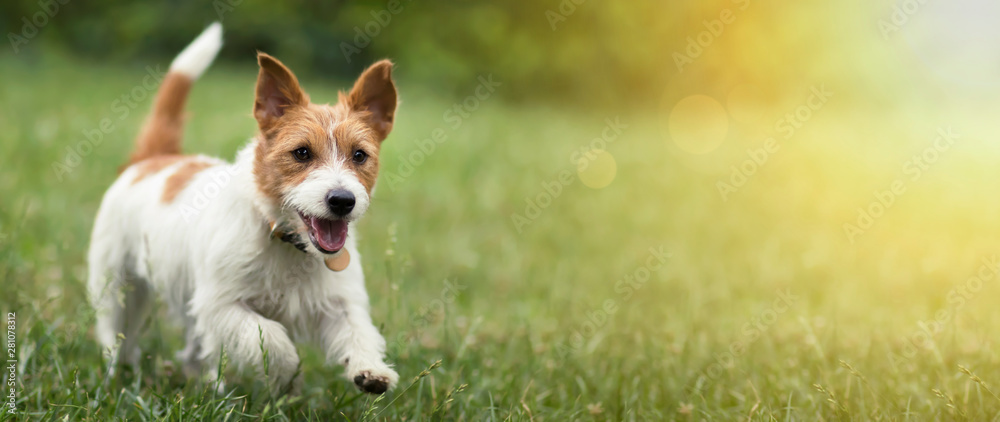

In [47]:
from PIL import Image
import io
Image.open(io.BytesIO(img_bytes))

In [48]:
response=predictor.predict(img_bytes, initial_args={"ContentType": "image/jpeg"})

In [49]:
import json
response2=predictor.predict(json.dumps(request_dict), initial_args={"ContentType": "application/json"})

In [50]:
type(response2[0][0])

float

In [51]:
response2[0]

[-1.2266345024108887,
 -2.2607765197753906,
 -1.0484769344329834,
 -0.40909042954444885,
 -1.3433412313461304,
 -1.6368234157562256,
 -0.21705250442028046,
 -1.593618631362915,
 -3.077537775039673,
 -0.640376091003418,
 -0.06675322353839874,
 -0.98823481798172,
 -0.3520350754261017,
 1.0271226167678833,
 -0.8231002688407898,
 1.2237026691436768,
 -2.620229721069336,
 -3.3450684547424316,
 -0.4939270615577698,
 -0.7444727420806885,
 -1.5793431997299194,
 -0.7066521644592285,
 -1.7530754804611206,
 -1.8026673793792725,
 -1.7475978136062622,
 -3.5712265968322754,
 -2.5624451637268066,
 -1.171671986579895,
 -0.21469798684120178,
 -0.5002591609954834,
 -0.6787208914756775,
 -1.5410836935043335,
 -3.759110450744629,
 -2.5280580520629883,
 -2.4074559211730957,
 -2.6655352115631104,
 -0.7482618689537048,
 -2.456573486328125,
 -0.599509596824646,
 -1.4226869344711304,
 -3.148080348968506,
 -2.1270785331726074,
 1.6497383117675781,
 -2.3844969272613525,
 -0.14273324608802795,
 -0.678817391395568

In [52]:
import torch
import numpy as np
np.argmax(response, 1)

array([42])